In [248]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from ipywidgets import interact
import pandas as pd
import seaborn as sns
from scipy.signal import lfilter
from scipy.stats import linregress

In [249]:
data = np.load("train_new.npy")
data.shape

(8, 8, 12220)

### Displaying data within a block

In [250]:
def plot_time_series(spatial_index, data):
    time_series = data[spatial_index[0], spatial_index[1], :]
    plt.figure(figsize=(20, 16))  # Set the figure size

    plt.plot(range(1, data.shape[2] + 1), time_series, label=f'Spatial Index {spatial_index}', linewidth=0.2)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'Time Series for Spatial Index {spatial_index}')
    plt.legend()
    plt.show()

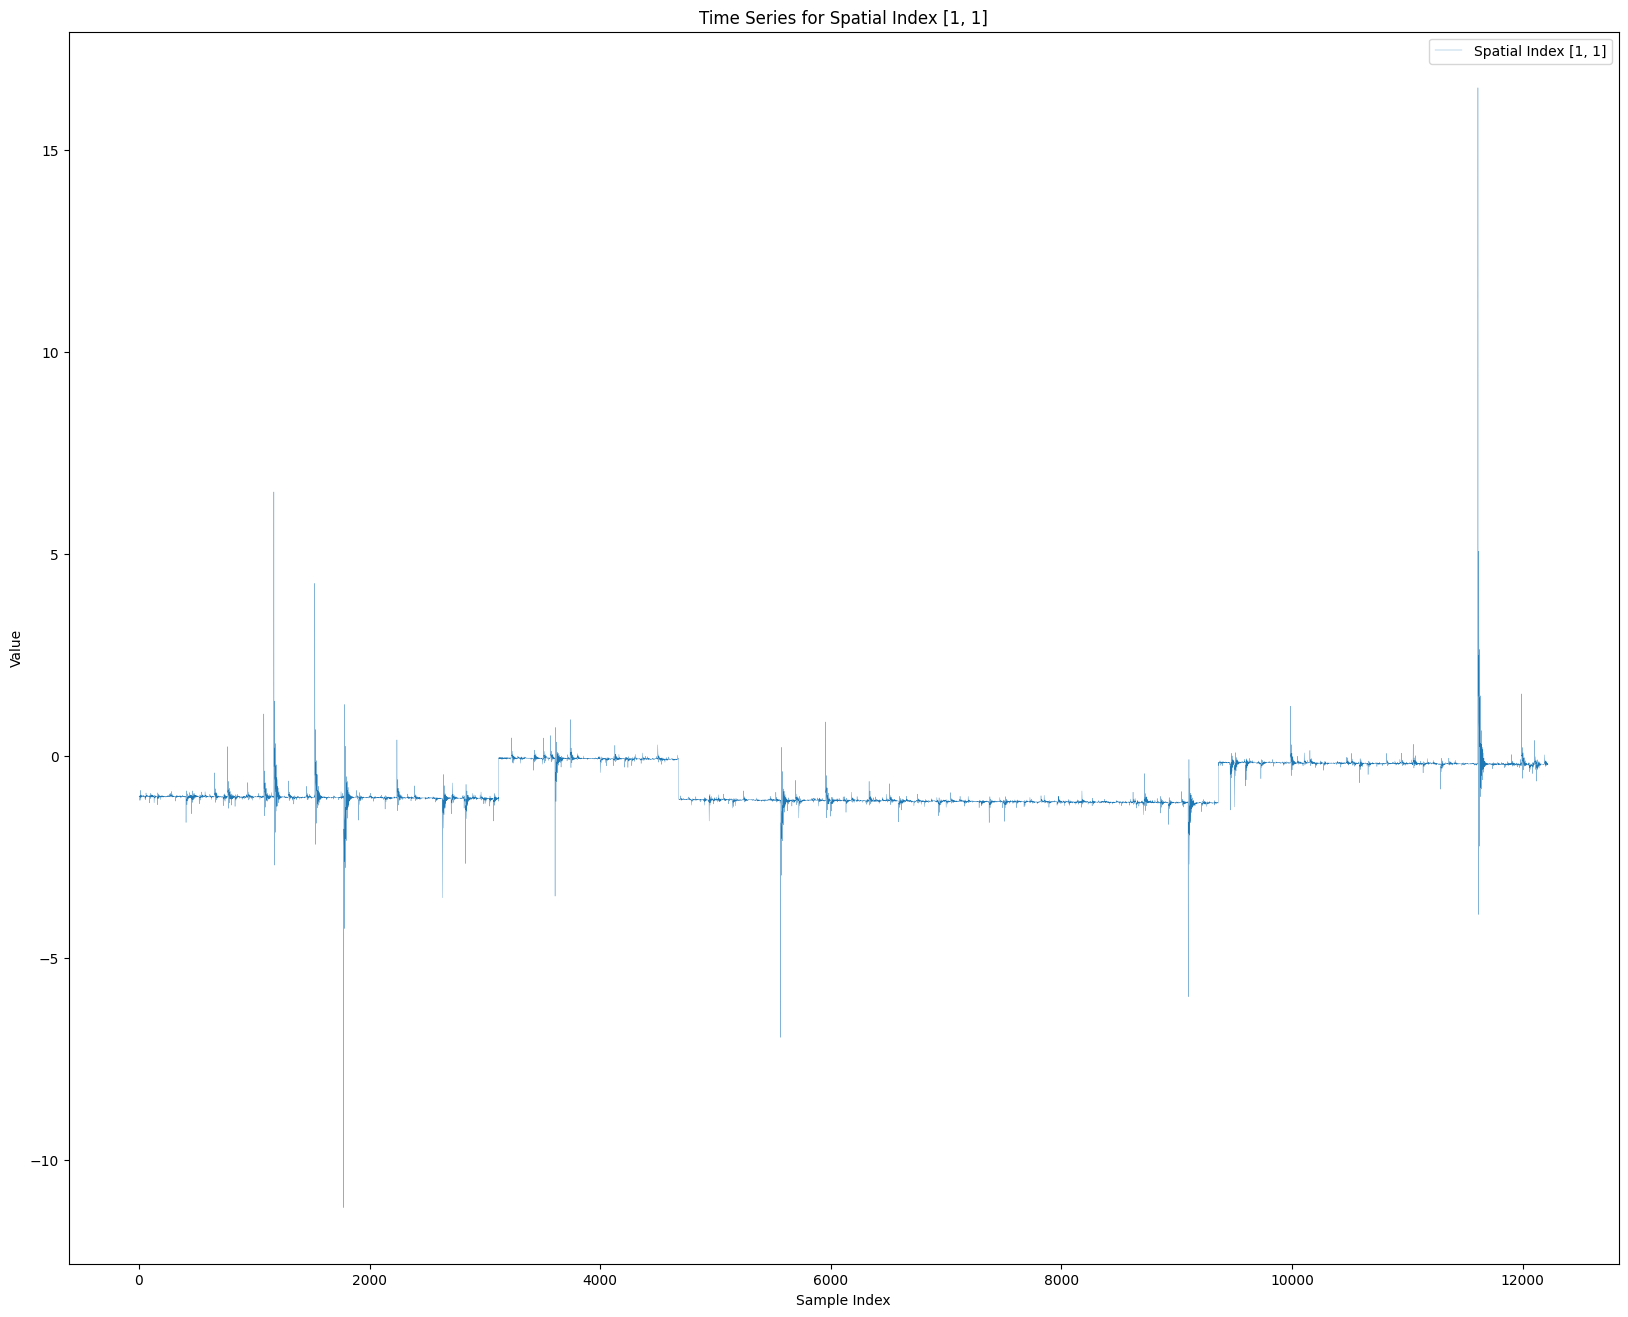

In [251]:
plot_time_series([1,1], data)

### Basic Outlier removement

In [252]:
data_without_oultier_simple = data.copy()
mask = (data_without_oultier_simple >= 1.5) | (data_without_oultier_simple <= -1.5)

data_without_oultier_simple[mask] = np.nan

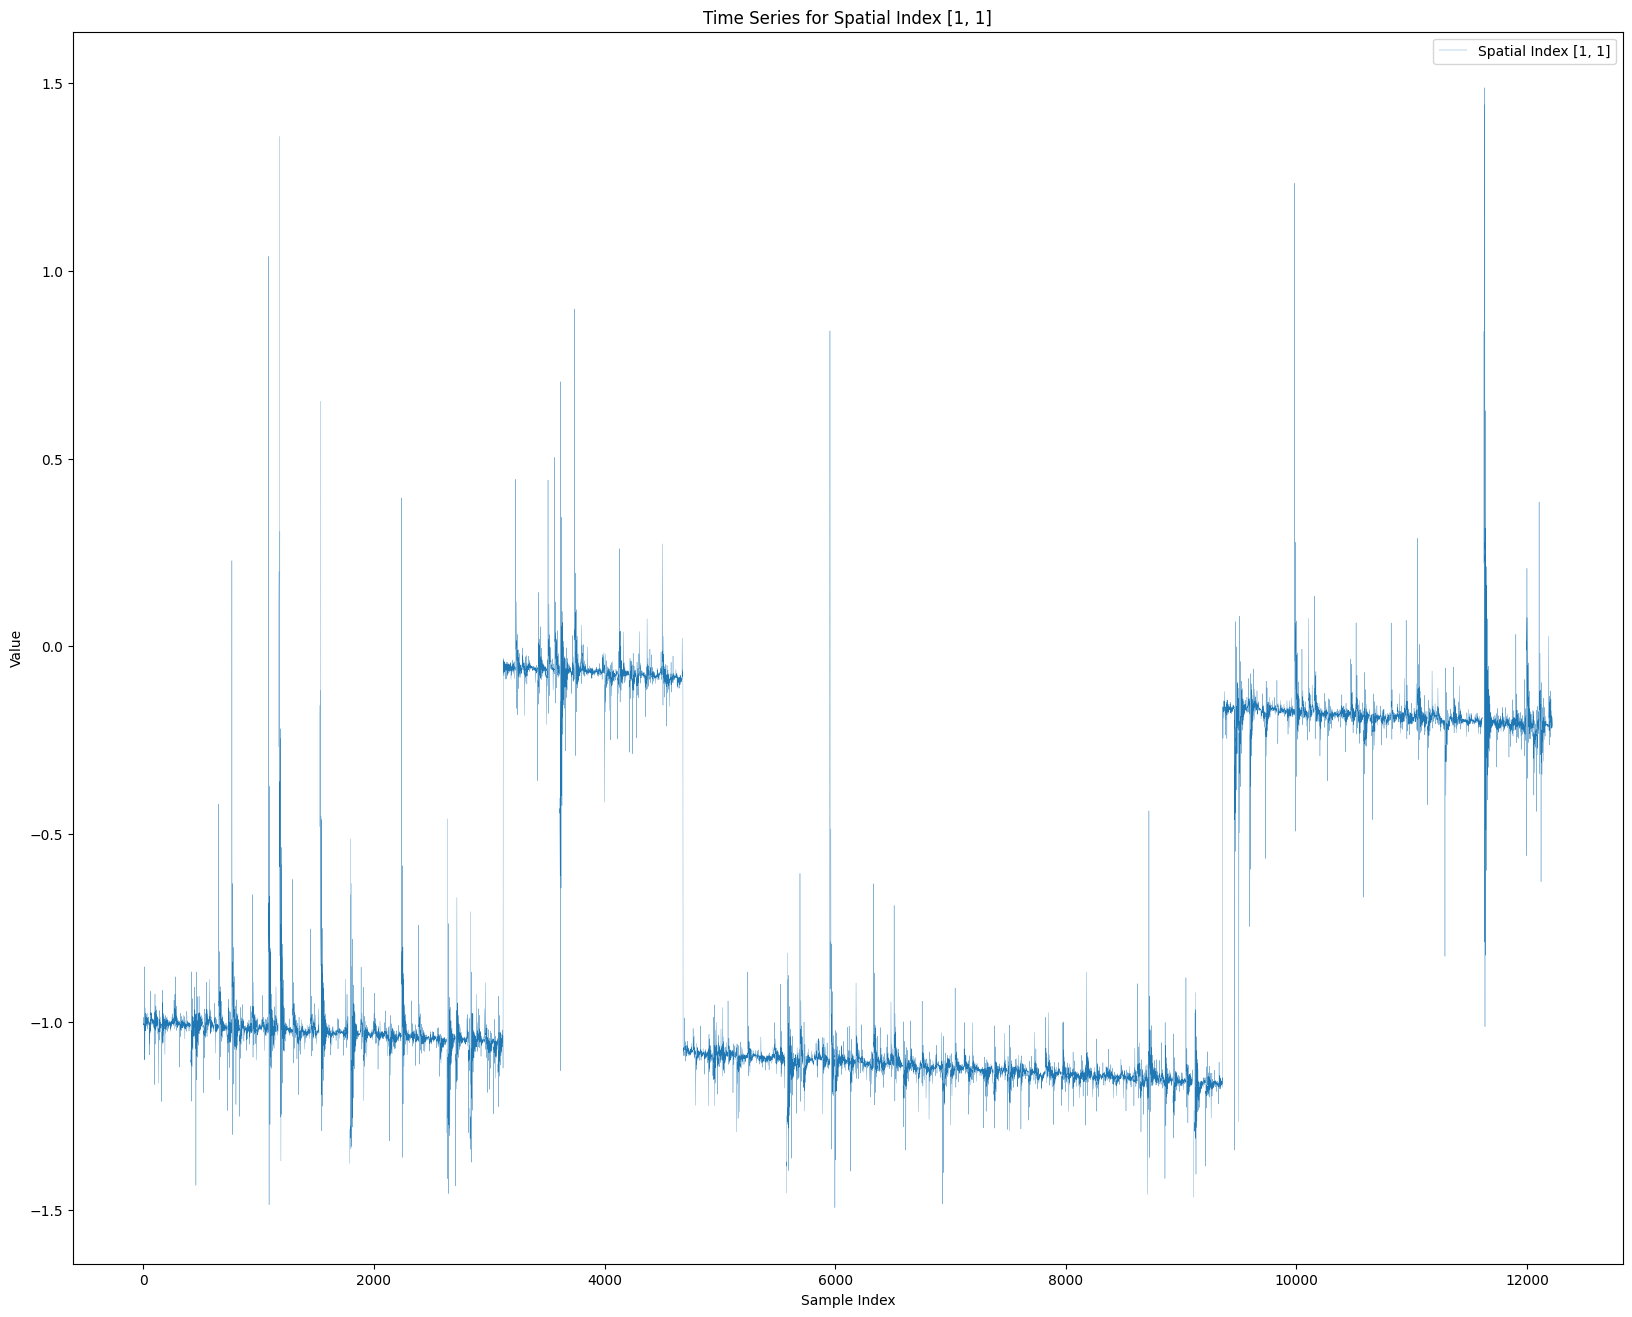

In [253]:
plot_time_series([1,1], data_without_oultier_simple)

### Visualicing the first 46 moves

In [254]:
data_new = data.copy()

block = 0
res = np.zeros((8, 8, 47))
for row in range(8):
    
    for col in range(8):

        block = np.clip(data_new[row,col,:], -1, 1)
        for n in range(47):
            res[row,col,n] = np.rint(np.mean(block[260*n:260*n+259]))


result = res


def conf_matrix(data):

    def plot_frame(frame):
        fig, ax = plt.subplots()
        im = ax.imshow(data[:, :, frame], cmap='viridis', interpolation='nearest', extent=[0.5, 8.5, 8.5, 0.5])
        plt.title(f"Frame {frame + 1}")
        plt.colorbar(im)
        
        for i in range(8):
            for j in range(8):
                value = data[i, j, frame]
                plt.text(j + 1, i + 1, f'{value:.2f}', color='white', ha='center', va='center', fontsize=8)

        plt.xticks(range(1, 9))
        plt.yticks(range(1, 9))
        plt.show()

    # Create an interactive scroller
    interact(plot_frame, frame=(0, data.shape[2] - 1, 1))

In [255]:
conf_matrix(res)

interactive(children=(IntSlider(value=23, description='frame', max=46), Output()), _dom_classes=('widget-inter…

### Filling the test set with the correct continuation of moves

In [256]:
pred_ = np.load("dummy_test_dataset.npy")
print(pred_.shape)

(8, 8, 10660)


In [257]:
moves = [[7,3, 4,3],
         [3,2, 4,3],
         [7,4, 1,4],
         [1,0, 2,1],
         [4,5, 4,3],
         [2,1, 3,0],
         [6,1, 4,1],
         [3,0, 4,0],
         [4,3, 5,2],
         [2,3, 3,3],
         [1,4, 1,0],
         [0,0, 1,1],
         [1,0, 1,1],
         [3,3, 4,2],
         [5,2, 2,5],
         [4,0, 5,0],
         [2,5, 2,0],
         [5,0, 4,1],
         [6,2, 5,2],
         [4,1, 5,2],
         [2,0, 7,0],
         [5,2, 6,3],
         [7,0, 6,1],
         [6,3, 7,3],
         [5,7, 7,5],
         [0,3, 6,3],
         [1,1, 1,3],
         [6,3, 1,3],
         [7,5, 4,2],
         [3,1, 4,2],
         [6,1, 0,7],
         [1,3, 5,3],
         [0,7, 0,0],
         [4,2, 5,2],
         [0,0, 4,0],
         [7,3, 7,4],
         [5,5, 4,5],
         [1,5, 3,5],
         [7,1, 7,2],
         [5,3, 6,3],
         [4,0, 1,0]
         ]

In [258]:
for j in range(260):        
    pred_[:,:,j] = result[:,:,46]

print(result[0,0,46])
for i in range(41):
    value = 0
    if i%2==0: value = 1
    else: value = -1 

    for j in range(260): 
        
        pred_[moves[i][0],moves[i][1],260*i+j] = 0
        pred_[moves[i][2],moves[i][3],260*i+j] = value

    if i < 40:
        pred_[:,:,(i+1)*260:(i+1)*260+260] = pred_[:,:,i*260:i*260+260]

pred_[:,:,10659] = pred_[:,:,10658]

#np.save("prediction.npy", pred_)

-1.0


In [259]:
conf_matrix(pred_)

interactive(children=(IntSlider(value=5329, description='frame', max=10659), Output()), _dom_classes=('widget-…

### Adding linear trend

In [260]:
spatial_index = (5,0)

selected_data = data_without_oultier_simple[spatial_index[0], spatial_index[1]].copy()
selected_data = selected_data[:]

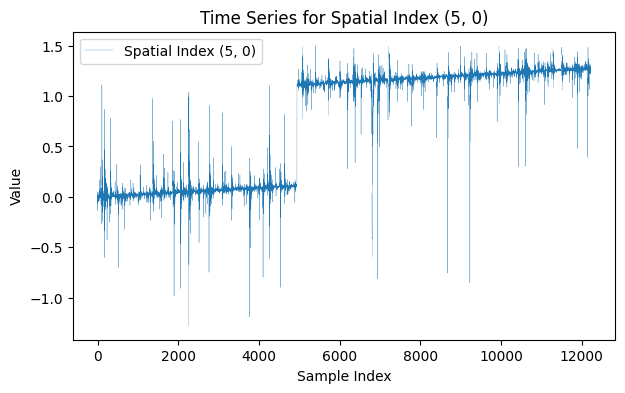

In [261]:
plt.figure(figsize=(7, 4))  # Set the figure size
plt.plot(range(1, len(selected_data) + 1), selected_data, label=f'Spatial Index {spatial_index}', linewidth=0.2)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title(f'Time Series for Spatial Index {spatial_index}')
plt.legend()
plt.show()

In [262]:
nan_indices = np.isnan(selected_data)

selected_data_without_nan = selected_data[~nan_indices]

In [241]:
y_values = selected_data_without_nan[:] # Replace this with your actual data

x_values = np.arange(len(y_values))

slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)
slope

0.00014056168908029774

In [263]:
def get_slope(data, spatial_index, interval, plot=False):

    selected_data = data[spatial_index[0], spatial_index[1]].copy()
    
    nan_indices = np.isnan(selected_data)
    print(len(nan_indices))
    selected_data = selected_data[~nan_indices]
    selected_data = selected_data[interval[0]:interval[1]]    

    y_values = selected_data 
    x_values = np.arange(len(y_values))

    slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)
    print(slope)

    linear_function = lambda x: slope * x + intercept

    x_linear_function = np.linspace(0, len(y_values) - 1, num=1000)
    y_linear_function = linear_function(x_linear_function)

    if plot:
        plt.figure(figsize=(12, 8)) 
        plt.plot(range(1, len(selected_data) + 1), selected_data, label=f'Spatial Index {spatial_index}', linewidth=0.2)
        plt.plot(x_linear_function, y_linear_function, color='red', label=f'Linear Function: y = {slope:.6f}x + {intercept:.2f}')

        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.title(f'Time Series for Spatial Index {spatial_index}')
        plt.legend()
        plt.show()
    
    return slope

12220
4.5961533089260936e-05


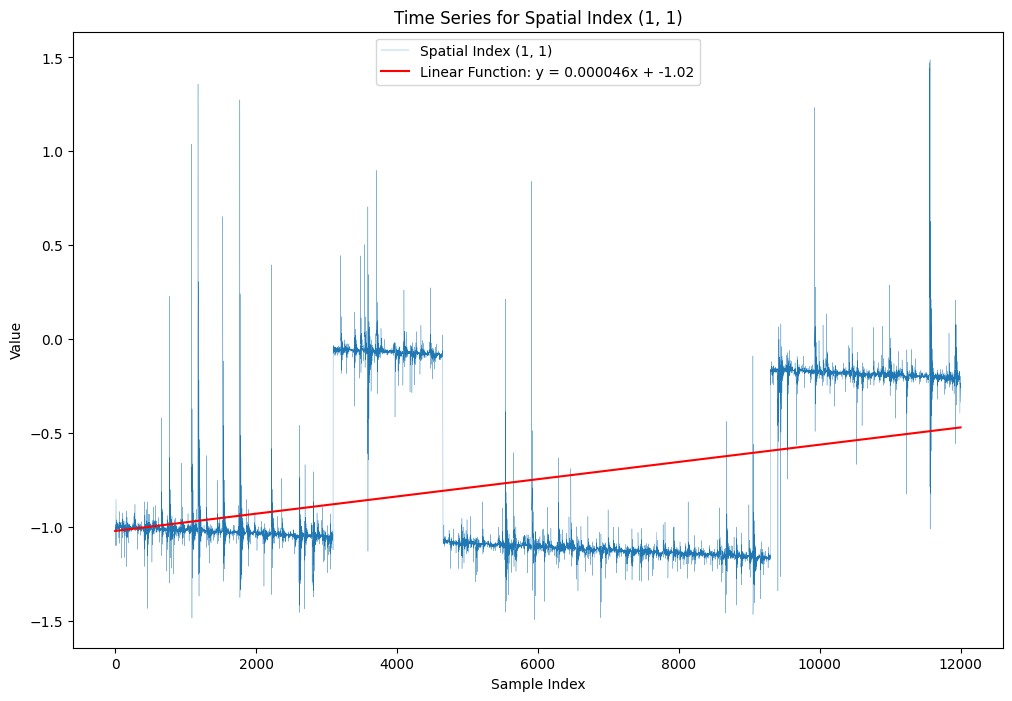

4.5961533089260936e-05

In [264]:
get_slope(data_without_oultier_simple,(1,1), (0,12000), True)
#get_slope(data_without_oultier_simple,(1,1), (5000,9000), True)
#get_slope(data_without_oultier_simple,(1,1), (0,3000), True)
#get_slope(data_without_oultier_simple,(1,1), (9500,12000), True)

### Calculate slope for all fields

In [265]:
def get_linear_funciton(data, spatial_index, plot=False):

    selected_data = data[spatial_index[0], spatial_index[1]]

    y_values = selected_data 
    x_values = np.arange(len(y_values))

    slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)
    #print(slope)

    linear_function = lambda x: slope * x + intercept

    x_linear_function = np.linspace(0, len(y_values) - 1, num=1000)
    y_linear_function = linear_function(x_linear_function)

    if plot:
        plt.figure(figsize=(12, 8)) 
        plt.plot(range(1, len(selected_data) + 1), selected_data, label=f'Spatial Index {spatial_index}', linewidth=0.2)
        plt.plot(x_linear_function, y_linear_function, color='red', label=f'Linear Function: y = {slope:.6f}x + {intercept:.2f}')

        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.title(f'Time Series for Spatial Index {spatial_index}')
        plt.legend()
        plt.show()
    
    return slope, intercept

-1.7216826928244717e-05


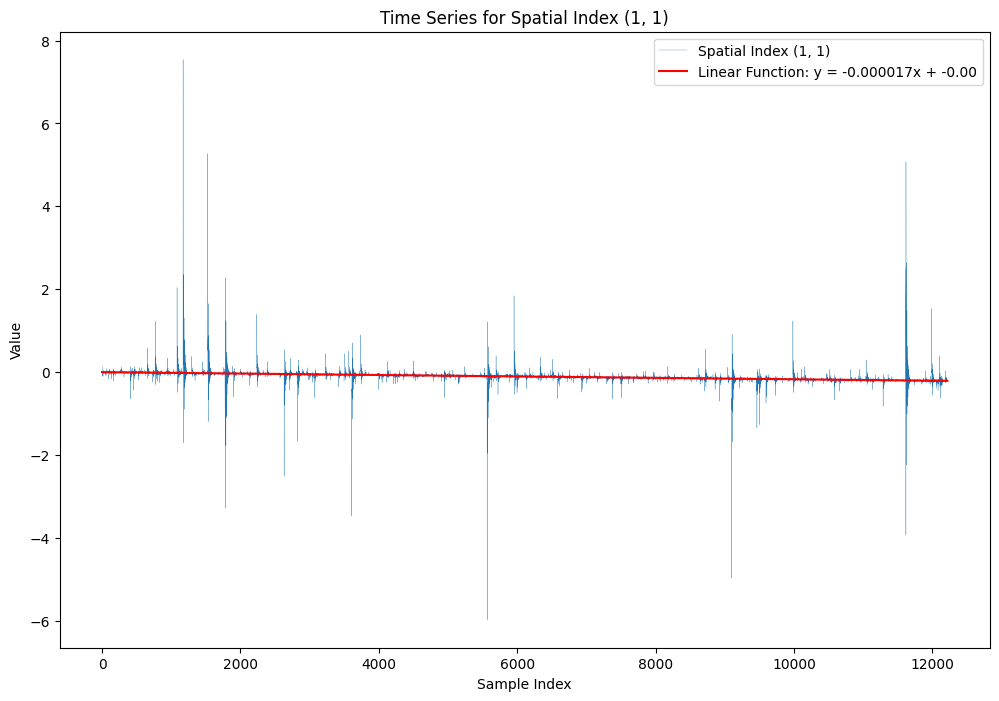

(-1.7216826928244717e-05, -0.00010507984703102269)

In [266]:
clean_moves = result.copy()
clean_data = data.copy()
cleaned_data = np.empty((8, 8), dtype=object)

# substract moves to get linear data
for i in range(46):
    for j in range(260):
        clean_data[:,:,260*i+j] -= clean_moves[:,:,i]

# remove outliers
mask = (clean_data >= 10) | (clean_data <= -10)
clean_data[mask] = np.nan

# remove nan

for i in range(clean_data.shape[0]):
    for j in range(clean_data.shape[1]):
        tmp = clean_data[i,j]
        nan_indices = np.isnan(tmp)
        tmp = tmp[~nan_indices] 
        cleaned_data[i,j] = tmp

#print(cleaned_data[1,1].shape)
get_linear_funciton(cleaned_data,(1,1), True)


In [267]:
linear_functions = np.zeros((8,8,2))

for i in range(cleaned_data.shape[0]):
    for j in range(cleaned_data.shape[1]):
        linear_functions[i,j] = get_linear_funciton(cleaned_data, (i,j))

print(linear_functions.shape)

1.3462683608173142e-05
-8.588333067231011e-06
-9.669451043260452e-06
1.4249098378351359e-05
-1.5406109368991803e-05
4.858405462753761e-06
8.60963803359234e-06
-4.497814640712463e-05
2.060642739928296e-05
-1.7216826928244717e-05
-1.468786925236707e-05
-2.1306979193997512e-06
-3.0384146864494477e-06
-3.888265323400034e-06
9.073167954689256e-06
7.013174342996236e-06
-3.865909621271896e-05
-1.793776117428799e-05
-1.0976262634686529e-05
-4.22857382995348e-08
-8.028356235242407e-06
-9.613019183300847e-07
-3.1836491767764976e-05
2.9688302395398592e-05
3.1808635659737917e-07
-1.8271733896790638e-05
-3.178700752952778e-05
4.8830909537146355e-05
-3.481639127348059e-05
3.7459208998769e-06
-2.483281709686124e-05
-2.154344790663412e-05
-1.94540753626034e-05
-2.0522458169521007e-05
2.3642736639633676e-05
3.1857624303621105e-05
-1.7156585210240327e-05
1.5050419654618691e-05
-1.1067212093781923e-05
-1.903414393315815e-05
3.183469060566709e-05
-5.203196810171004e-06
-2.8419059286578258e-05
-4.132682214